# Exploration des données de Sirene

## Importation des différents packages nécessaires.

In [1]:
import pandas as pd
import dask.dataframe as dd
import random
import itertools
import numpy as np
from datetime import datetime
from tqdm import tqdm
import nltk
import string
import swifter
from nltk.corpus import stopwords
import fasttext
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/coder/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Importation des données

In [2]:
DBRaw = dd.read_parquet('../data/extraction_sirene_20220510.parquet', engine='pyarrow')

Temporaire : On restreint les données à 1% de la base initiales.

In [3]:
DBRaw = DBRaw.sample(frac= 0.01, random_state=1234)

On transforme les valeurs manquantes en NaN.

In [4]:
DBRaw = DBRaw.fillna(value=np.nan)

On garde seulement les variables potentiellement intéressantes : 
- ``APE_SICORE :`` Code APE (Activité Principale Exercée) retenu lors du traitement de codification (soit Sicore soit gestionnaire) ;
- ``NAT_SICORE :`` Nature de l'activité de l'entreprise ;
- ``SED_SICORE :`` Sédentarité de l'entreprise ;
- ``EVT_SICORE :`` Sédentarité de l'entreprise ;
- ``LIB_SICORE :`` Sédentarité de l'entreprise ;
- ``DATE :`` Sédentarité de l'entreprise ;
- ``AUTO :`` Type de liasse extrait de la base brute Sirène ;
- ``SURF :`` Surface en $m^2$ de l'établissement.


In [5]:
Var2Keep = ["APE_SICORE","LIB_SICORE","AUTO","DATE","NAT_SICORE","SED_SICORE","EVT_SICORE","SURF"]
DB = DBRaw[Var2Keep]

On supprime les liasses où une valeur est manquante pour l'une de ces deux variables (6.77% de la base). Il s'agit principalement du code APE donc il n'est pas nécessaire de l'imputer.

In [6]:
DB = DB.dropna(subset=['APE_SICORE'])  

On a finalement 10.8 millions de liasses.

In [ ]:
DB.shape[0].compute()

## I- Modèle 1

On estime un modèle FastText standard en utilisant seulement les libellés comme features.

### 1) Preprocessing 

In [7]:
DB1 = DB[["APE_SICORE","LIB_SICORE"]]
DB1 = DB1.dropna(subset=['LIB_SICORE'])  

In [8]:
stopwords_ = set(stopwords.words('french') + ['a'])
def CleanLib(lib):
    # On supprime toutes les ponctuations
    lib = lib.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    # On supprime tous les chiffres
    lib = lib.translate(str.maketrans(string.digits, ' ' * len(string.digits)))

    # On supprime les stopwords et on renvoie les mots en majuscule
    return " ".join([x.lower() for x in lib.split() if x.lower() not in stopwords_])

In [9]:
DB1["LIB_CLEAN"] = DB1["LIB_SICORE"].apply(lambda x: CleanLib(x), meta=pd.Series(dtype='str', name='LIB_CLEAN'))
df = DB1.compute()

### 2) Splitting

On mélange de manière aléatoires les index puis on les divise en 2 groupes selon un certain pourcentage (ici 80% et 20%)


In [11]:
random.seed(123456)
Idx = random.sample(df.index.values.tolist(), df.shape[0])
Groups = np.split(Idx, [int(len(Idx)*0.8)])

In [ ]:
with open("../data/train_text.txt", 'w') as f:
    for idx in range(len(Groups[0])):
        aLine = "__label__{} {}".format(df.at[Groups[0][idx],"APE_SICORE"], df.at[Groups[0][idx],"LIB_CLEAN"])
        f.write("%s\n" % aLine)


### 3) Training

On définit plusieurs options pour le modèle.

In [ ]:
config_fasttext={"dim": 150,
"lr": 0.2,
"epoch": 80,
"wordNgrams": 3,
"minn": 3,
"maxn": 4,
"minCount": 3,
"bucket": 3000000,
"thread": 25,
"loss": 'ova',
"label_prefix": '__label__'}

In [18]:
#model1 = fasttext.train_supervised(input="../data/train_text.txt", **config_fasttext)
model1 = fasttext.load_model("../models/fasttextmodel1.bin")

In [19]:
TypeData = ["Train", "Test"]
dico_lib= { TypeData[i] : {Groups[i][idx] : {"TrueValue" : df.at[Groups[1][idx],"APE_SICORE"],
                                                "Libelle" : df.at[Groups[1][idx],"LIB_CLEAN"]} 
                                                for idx in range(len(Groups[1]))
                            } for i in range(len(TypeData))
}

### Evaluation du modèle

In [ ]:
def get_pred(lib, mod):
    out = mod.predict(lib)
    pred5 = out[0][0].replace("__label__","")
    prob = out[1][0]
    return [pred, prob]

Accuracy of the training set

In [165]:
df_train = df.loc[Groups[0], :]
df_train[['PREDICTION', 'PROBA']] = df_train['LIB_CLEAN'].swifter.apply(lambda x: get_pred(x, model1)).to_list()
df_train['GoodPREDICTION'] = df_train['APE_SICORE'] == df_train['PREDICTION']
for i in range(2,5):
    df_train['PREDICTION_NIV'+ str(i)] = df_train['PREDICTION'].str[:i]
    
sum(df_train['GoodPREDICTION'])/df_train.shape[0] * 100

Pandas Apply:   0%|          | 0/87128 [00:00<?, ?it/s]

84.77068221467266

Accuracy of the testing set

In [166]:
df_test = df.loc[Groups[1], :]
df_test[['PREDICTION', 'PROBA']] = df_test['LIB_CLEAN'].swifter.apply(lambda x: get_pred(x, model1)).to_list()
df_test['GoodPREDICTION'] = df_test['APE_SICORE'] == df_test['PREDICTION']
for i in range(2,5):
    df_test['PREDICTION_NIV'+ str(i)] = df_test['PREDICTION'].str[:i]

sum(df_test['GoodPREDICTION'])/df_test.shape[0] * 100

Pandas Apply:   0%|          | 0/21783 [00:00<?, ?it/s]

85.27750998485058

On importe un document qui contient des informations sur les différents codes APE

In [167]:
df_naf =  pd.read_csv(r"../data/naf_extended.csv",sep=",",encoding="utf-8",dtype=str)
df_naf[["NIV3","NIV4","NIV5"]] = df_naf[["NIV3","NIV4","NIV5"]].apply(lambda x: x.str.replace('.', ''))
df_naf.set_index("NIV5", inplace=True)

On calcule la prédiction pour le niveau 1 grâce à la table importée

In [168]:
df_test['PREDICTION_NIV1'] = df_test["PREDICTION_NIV2"].swifter.apply(lambda x : pd.unique(df_naf["NIV1"][df_naf["NIV2"]== x])[0])
df_train['PREDICTION_NIV1'] = df_train["PREDICTION_NIV2"].swifter.apply(lambda x : pd.unique(df_naf["NIV1"][df_naf["NIV2"]== x])[0])

Pandas Apply:   0%|          | 0/21783 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/87128 [00:00<?, ?it/s]

On regarde la precision le rappel et le F1 pour les différentes classes désaggrégées (Niveau 5)

In [169]:
df_naf = df_naf.join(df_train.groupby(['APE_SICORE']).size().rename("Size_TRAIN").to_frame())
df_naf = df_naf.join(df_test.groupby(['APE_SICORE']).size().rename("Size_TEST").to_frame())
df_naf = df_naf.join(df_test.groupby(['APE_SICORE']).mean('GoodPREDICTION').rename(columns={"GoodPREDICTION":"Recall_TEST"}))
df_naf = df_naf.join(df_test.groupby(['PREDICTION']).mean('GoodPREDICTION').rename(columns={"GoodPREDICTION":"Precision_TEST"}))
df_naf = df_naf.join(2 * 1/(1/df_naf["Precision_TEST"] + 1/df_naf["Recall_TEST"]).rename("F1_TEST").to_frame())

On fait la même chose pour le niveau le plus aggrégé (Niveau 1)

In [170]:
for aNiv in tqdm(["NIV1","NIV2","NIV3"]):
    df_test["APE_" + aNiv] = df_test["APE_SICORE"].apply(lambda x : df_naf.loc[x][aNiv])
    df_train["APE_" + aNiv] = df_train["APE_SICORE"].apply(lambda x : df_naf.loc[x][aNiv])

100%|██████████| 3/3 [00:37<00:00, 12.53s/it]


In [185]:
Results_NIV1 = df_train.groupby(['APE_NIV1']).size().rename("Size_TRAIN").to_frame()
Results_NIV1 = Results_NIV1.join(df_test.groupby(['APE_NIV1']).size().rename("Size_TEST").to_frame())
Results_NIV1 = Results_NIV1.join(df_test.groupby(['APE_NIV1']).mean('GoodPREDICTION').rename(columns={"GoodPREDICTION":"Recall_TEST"}))
Results_NIV1 = Results_NIV1.join(df_test.groupby(['PREDICTION_NIV1']).mean('GoodPREDICTION').rename(columns={"GoodPREDICTION":"Precision_TEST"}))
Results_NIV1 = Results_NIV1.join(2 * 1/(1/Results_NIV1["Precision_TEST"] + 1/Results_NIV1["Recall_TEST"]).rename("F1_TEST").to_frame())
Results_NIV1["LIB_NIV1"] = [pd.unique(df_naf["LIB_NIV1"][df_naf["NIV1"]== x])[0] for x in Results_NIV1.index.values]

In [186]:
Results_NIV1

,Size_TRAIN,Size_TEST,Recall_TEST,Precision_TEST,F1_TEST,LIB_NIV1
APE_NIV1,,,,,,
A,2341,631,0.882726,0.799139,0.838855,"Agriculture, sylviculture et pêche"
B,19,6,1.000000,1.000000,1.000000,Industries extractives
C,3153,801,0.779026,0.855967,0.815686,Industrie manufacturière
D,765,175,0.982857,0.934783,0.958217,"Production et distribution d'électricité, de g..."
E,203,54,0.722222,0.780000,0.750000,Production et distribution d'eau ; assainissem...
F,6971,1743,0.865175,0.872180,0.868664,Construction
G,14452,3644,0.806257,0.811602,0.808921,Commerce ; réparation d'automobiles et de moto...
H,4905,1209,0.916460,0.894992,0.905599,Transports et entreposage
I,3798,922,0.848156,0.890661,0.868889,Hébergement et restauration


In [188]:
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

In [203]:
y_true = df_test.APE_NIV1.to_list()
y_pred = df_test.PREDICTION_NIV1.to_list()

In [210]:
[ x for x in df_test.APE_NIV1.to_list() if x not in y_true]

[]

In [206]:
from sklearn.metrics import confusion_matrix

array([[ 611,    0,    1,    1,    0,    0,    5,    1,    1,    0,    0,
           5,    3,    0,    0,    0,    0,    1,    2,    0],
       [   0,    6,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  15,    0,  678,    0,    0,   19,   33,    0,    6,   12,    1,
           5,   24,    4,    1,    2,    1,    0,    0,    0],
       [   0,    0,    0,  173,    0,    0,    1,    0,    0,    0,    0,
           0,    0,    1,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    2,   42,    1,    3,    0,    0,    0,    0,
           0,    0,    1,    2,    0,    0,    0,    2,    0],
       [   3,    0,    7,    2,    1, 1645,    4,    3,    2,   11,    2,
          31,    9,   16,    0,    0,    0,    5,    2,    0],
       [  25,    0,   23,    1,    6,   18, 3447,    6,   13,   20,    5,
          20,   20,   20,    0,    4,    3,    2,   11,    0],
       [   0,    0,    0,    1,    0,    

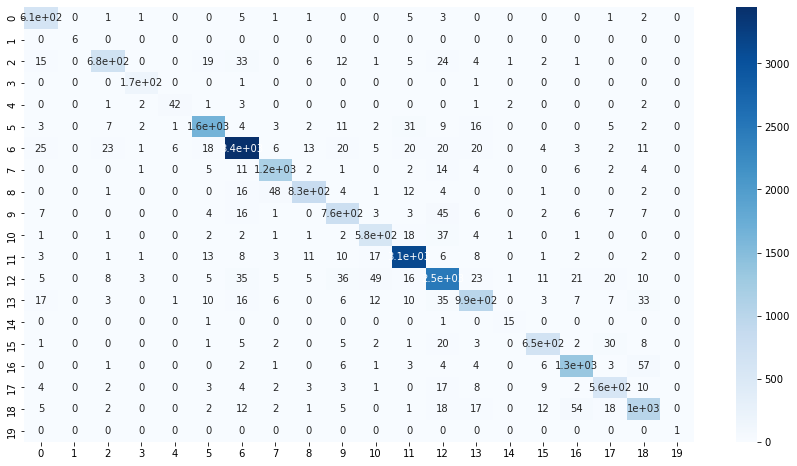

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (15,8))
ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')

- matrice de confusin poiur chaque sous groupe
- hyper parametres
- checker les libellés, leurs qualité, stats descr
- 